In [1]:
import os
import cv2
import json
import time
import torch
import random
import zipfile
import requests
import numpy as np
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw, ImageFilter, ImageOps

repo_dir = "c:/Users/James/git/de-identification/"
data_path = repo_dir+"downloaded-data/"
base_dir = "C:/Users/James/"


# Setting up Kaggle - copying api key from repo to .kaggle folder
with open(repo_dir+'kaggle-apikey.json') as f:
    kaggle_apikey = json.load(f)
kaggle_apikey

kaggle_dir = base_dir + '.kaggle'
print("base_dir:", base_dir)
print("kaggle_dir:", kaggle_dir)
if not os.path.exists(kaggle_dir): 
    print("making folder: ", kaggle_dir)
    os.mkdir(kaggle_dir)

with open(kaggle_dir+'/kaggle.json', 'w') as f:
    json.dump(kaggle_apikey, f)

#Checking it has been created correctly
with open(kaggle_dir+'/kaggle.json', 'r') as f:
    print('~/.kaggle/kaggle.json ==', f.read())

import kaggle


if not os.path.exists(data_path): 
    print("Creating folder: ", data_path)
    os.mkdir(data_path)
!kaggle config set -n path -v {data_path}

base_dir: C:/Users/James/
kaggle_dir: C:/Users/James/.kaggle
~/.kaggle/kaggle.json == {"username": "jamesdavey", "key": "a8975caa44cfa08d6f2164f2d5977b6e"}
- path is now set to: c:/Users/James/git/de-identification/downloaded-data/


In [ ]:
### Downloading CelebA dataset ###
# ! kaggle datasets download jessicali9530/celeba-dataset 
zip_path = data_path+"datasets/jessicali9530/celeba-dataset/celeba-dataset.zip"
with zipfile.ZipFile(zip_path,"r") as zip_ref:
    zip_ref.extractall(data_path)
#put in folder downloaded-data/img_align_celeba/img_align_celeba/[img1, img2, ...]

In [ ]:
### Downloading vin1234/count-the-number-of-faces-present-in-an-image ###
! kaggle datasets download vin1234/count-the-number-of-faces-present-in-an-image
zip_path = data_path+"datasets/vin1234/count-the-number-of-faces-present-in-an-image/count-the-number-of-faces-present-in-an-image.zip"
with zipfile.ZipFile(zip_path,"r") as zip_ref:
    zip_ref.extractall(data_path)
# #put in folder downloaded-data/train/image_data/[img1, img2, ...]

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))
mtcnn = MTCNN(keep_all=True, device=device)

celeba_datapath = data_path+"img_align_celeba/img_align_celeba/"
group_images = data_path+"train/image_data/"
 
print("Length of celeba_filenames:", len(os.listdir(celeba_datapath)))
print("Length of group_filenames:", len(os.listdir(group_images)))

Running on device: cpu
Length of celeba_filenames: 202599
Length of group_filenames: 8196


Processed 0 images
Processed 100 images
Processed 200 images
Processed 300 images
Processed 400 images
Processed 500 images
Processed 600 images
Processed 700 images
Processed 800 images
Processed 900 images
Processed 1000 images
Processed 1100 images
Processed 1200 images
Processed 1300 images
Processed 1400 images
Processed 1500 images
Processed 1600 images
Processed 1700 images
Processed 1800 images
Processed 1900 images
Processed 2000 images
Processed 2100 images
Processed 2200 images
Processed 2300 images
Processed 2400 images
Processed 2500 images
Size:  42 80


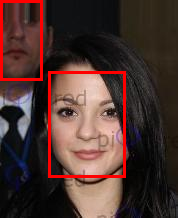

Processed 2600 images
Processed 2700 images
Processed 2800 images
Processed 2900 images
Processed 3000 images
Processed 3100 images
Processed 3200 images


KeyboardInterrupt: 

In [4]:
small_images_ignored = 0

def generate_boxes(img, threshold=0.7):
    global small_images_ignored

    all_boxes, probs, landmarks = mtcnn.detect(img.copy(), landmarks=True)
    if all_boxes is None: return []
    all_boxes = [[int(x) for x in box] for box in all_boxes] 
    #gives box values outside of image, e.g. [-6, 135, 69, 229],
    all_boxes = [[max(0, box[0]), max(0, box[1]), box[2], box[3]] for box in all_boxes]
    boxes = []
    for box, prob in zip(all_boxes, probs):
        width = box[2] - box[0]
        height = box[3] - box[1]
        #minimum requirement??
        if prob >= threshold:
            if width > 30 and height > 30:
                boxes.append(box)
            else:
                small_images_ignored+=1
    return boxes

def draw_boxes(img, boxes):
    frame_draw = img.copy()
    draw = ImageDraw.Draw(frame_draw)
    for box in boxes:
        draw.rectangle(box, outline=(255, 0, 0), width=3) # box = (x1, y1, x2, y2)
    return frame_draw

def get_boxes(images_dir):
    filenames = os.listdir(celeba_datapath)
    for i, image_filename in enumerate(filenames):
        image_path = images_dir + image_filename
        img = Image.open(image_path)
        boxes = generate_boxes(img)
        
        for box in boxes[:1]: # only first box (most probable and most likely main face)
            height = box[3] - box[1]
            width = box[2] - box[0]
            if height < 64 or width < 64:
                print("Size: ", box[2]-box[0], box[3]-box[1])
                display(draw_boxes(img, boxes))

        if i % 100 == 0:
            print("Processed", i, "images")

get_boxes(celeba_datapath) #group_images



    # display(img)

In [ ]:
#To do:
#crop and resize the image before I create the faces dataset
# for the group images consider if they're high enough quality for training
# - I only wanna train on faces 64x64 or better resolution

In [ ]:
# ## This dataset will be for the resting generated 64x64 images

# class ImageDataset(Dataset):
#     def __init__(self, root, transform):
#         self.root = root
#         self.transform = transform
#         self.all_imgs = list(sorted(os.listdir(root)))

#     def __len__(self):
#         return len(self.all_imgs)

#     def __getitem__(self, idx):
#         image = Image.open(self.root+self.all_imgs[idx])
#         image = self.transform(image)
#         return image

# batch_size = 16
# image_size=64

# img_transform=transforms.Compose([
#                                transforms.Resize(image_size),
#                                transforms.CenterCrop(image_size),
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# celeba_datapath = data_path+"img_align_celeba/img_align_celeba/"
# group_images = data_path+"train/image_data/"

# assert len(os.listdir(celeba_datapath)) > 0 and  len(os.listdir(group_images)) > 0, "No images found in data path"
# celeba_dataset = ImageDataset(celeba_datapath, img_transform)
# celeba_dataloader = DataLoader(celeba_dataset, batch_size=batch_size, shuffle=True)
# batch = next(iter(celeba_dataloader))
# display_img = Image.fromarray((vutils.make_grid(batch, padding=2, normalize=True).permute(1,2,0).numpy()*255).astype(np.uint8))
# display(ImageOps.contain(display_img, (2048,2048)))

# group_dataset = ImageDataset(group_images, img_transform)
# group_dataloader = DataLoader(group_dataset, batch_size=batch_size, shuffle=True)
# batch = next(iter(group_dataloader))
# display_img = Image.fromarray((vutils.make_grid(batch, padding=2, normalize=True).permute(1,2,0).numpy()*255).astype(np.uint8))
# ImageOps.contain(display_img, (2048,2048))